In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=6*1024)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


2026-01-26 03:40:54.399493: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1769398855.703834  795954 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6144 MB memory:  -> device: 0, name: AMD Radeon RX 9070 XT, pci bus id: 0000:03:00.0


In [3]:
# Data processing and model train

from libs.ml import AtmosphericalData
from tensorflow import keras
from keras.src.callbacks import EarlyStopping
def train_model(target_column:str, date_col: str, train_column: str, n_steps:int, training_args: dict, model_args: list, compile_args: dict = None):
    ## Read data and preprocessing

    inside = []
    for v in model_args:
        layer = getattr(keras.layers, v['layer'])

        inside.append(layer(v['units'], **v['args']))

    model = keras.models.Sequential(inside)

    ad = AtmosphericalData(model=model, path=f"./data/{target_column}/{target_column}_decomposition.csv", use_cudnn=False)
    del model

    print(ad.df.columns)

    ad.convert_date(date_col=date_col)
    ad.target_selection(train_column)
    ad.data_preprocessing(n_steps=n_steps, train_vol=0.9)

    ## Train data
    ad.train_data(
        epochs=training_args['epochs'],
        batch_size=training_args['batch_size'],
        validation_split=training_args['validation_split'],
        verbose=training_args['verbose'],
        **compile_args
    )


    ## Test trained model
    ad.test_model()


    ## Plot comparison
    ad.plot_tests()

    return ad

In [4]:
target = 'ws(mps)'

Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (774, 6, 3)
y shape: (774,)
Epoch 1/150


2026-01-26 03:40:56.741158: I external/local_xla/xla/service/service.cc:163] XLA service 0x713050004d50 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
2026-01-26 03:40:56.741171: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): AMD Radeon RX 9070 XT, AMDGPU ISA version: gfx1201
2026-01-26 03:40:56.758020: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-26 03:40:56.876290: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4501 - mae: 0.8341

I0000 00:00:1769398857.814195 1122688 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2026-01-26 03:40:58.012516: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.4435 - mae: 0.8211 - val_loss: 0.3360 - val_mae: 0.6792
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4338 - mae: 0.8098 - val_loss: 0.3343 - val_mae: 0.6775
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4262 - mae: 0.8003 - val_loss: 0.3322 - val_mae: 0.6747
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4207 - mae: 0.7929 - val_loss: 0.3324 - val_mae: 0.6767
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4168 - mae: 0.7875 - val_loss: 0.3343 - val_mae: 0.6804
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4141 - mae: 0.7831 - val_loss: 0.3350 - val_mae: 0.6825
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4121 - mae: 0.7803 - val_loss: 0.3368 - val_mae: 0.6856
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4114 - mae: 0.7787 - val_loss: 0.3371 - val_mae: 0.6878
Epoch 9/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4110 - mae: 0.

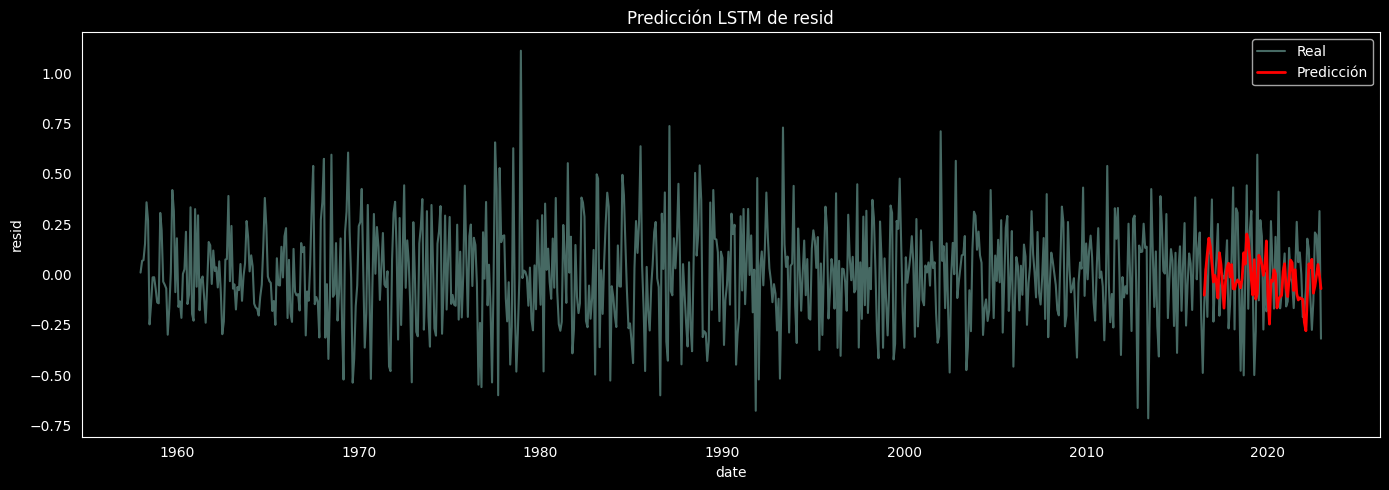

In [5]:
n_steps_r = 6

model_args_r = [
    {'layer': 'Input', 'units': (n_steps_r, 3), 'args': {}},
    {'layer': 'LSTM', 'units':16, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_r = {
    'optimizer': 'adam',
    'loss': 'huber',
    'metrics': ['mae'],
}

training_args_r = {
    'epochs': 150,
    'batch_size': 16,
    'validation_split': 0.2,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 1
}

ad_r = train_model(
    target_column=target,
    date_col='date',
    train_column='resid',
    n_steps=n_steps_r,
    training_args=training_args_r,
    model_args=model_args_r,
    compile_args=compile_args_r
)

Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (756, 24, 3)
y shape: (756,)
Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 1.0125 - mse: 1.0125 - val_loss: 0.0699 - val_mse: 0.0699
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3682 - mse: 0.3682 - val_loss: 0.0805 - val_mse: 0.0805
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1816 - mse: 0.1816 - val_loss: 0.0433 - val_mse: 0.0433
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1097 - mse: 0.1097 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0741 - mse: 0.0741 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0578 - mse: 0.0578 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

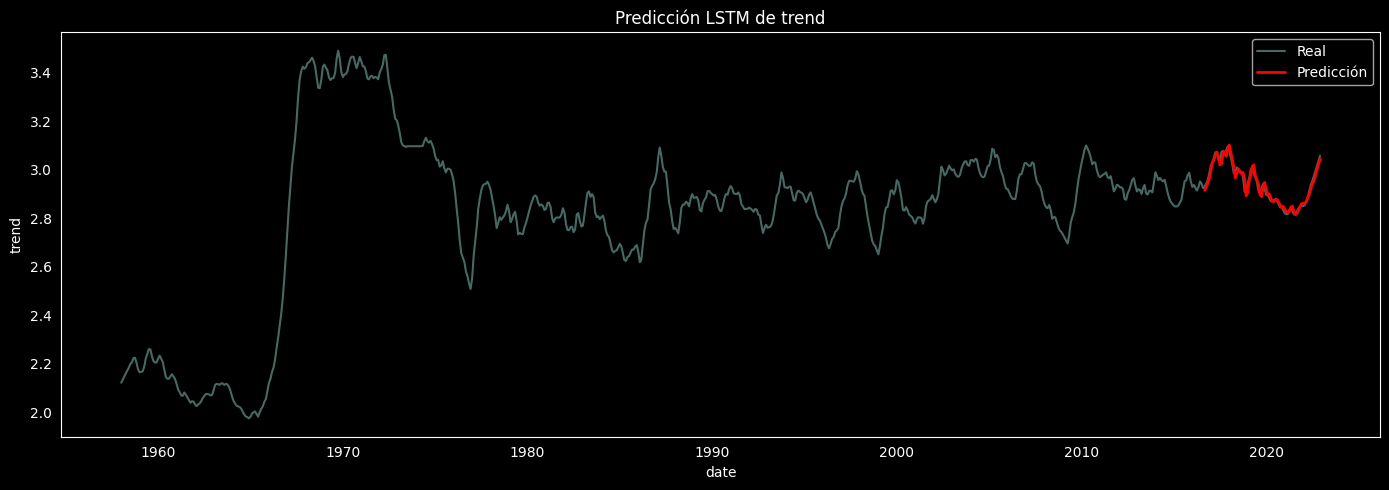

In [6]:
n_steps_t = 24
model_args_t = [
    {'layer': 'Input', 'units': (n_steps_t, 3), 'args': {}},
    {'layer': 'LSTM', 'units':32, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_t = {
    'optimizer': 'adam',
    'loss': 'mse',
    'metrics': ['mse'],
}

training_args_t = {
    'epochs': 150,
    'batch_size': 24,
    'validation_split': 0.15,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 1
}

ad_t = train_model(
    target_column=target,
    date_col='date',
    train_column='trend',
    n_steps=n_steps_t,
    training_args=training_args_t,
    model_args=model_args_t,
    compile_args=compile_args_t
)


Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (768, 12, 3)
y shape: (768,)
Epoch 1/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.5508 - mse: 0.5508 - val_loss: 0.0958 - val_mse: 0.0958
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.0406 - val_mse: 0.0406
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0404 - mse: 0.0404 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0295 - mse: 0.0295 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

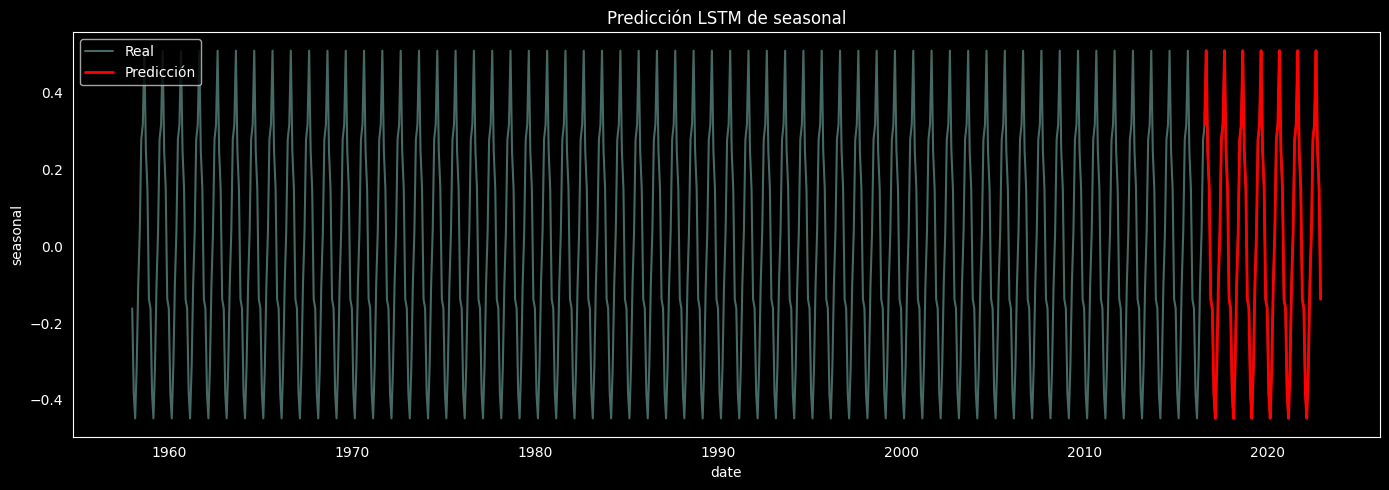

In [7]:
n_steps_s = 12

model_args_s = [
    {'layer': 'Input', 'units': (n_steps_s, 3), 'args': {}},
    {'layer': 'LSTM', 'units':32, 'args': {'return_sequences': True, 'use_cudnn': False}},
    {'layer': 'LSTM', 'units':16, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_s = {
    'optimizer': 'adam',
    'loss': 'mse',
    'metrics': ['mse'],
}

training_args_s = {
    'epochs': 150,
    'batch_size': 16,
    'validation_split': 0.15,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 1
}

ad_s = train_model(
    target_column=target,
    date_col='date',
    train_column='seasonal',
    n_steps=n_steps_s,
    training_args=training_args_s,
    model_args=model_args_s,
    compile_args=compile_args_s
)


Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (756, 24, 3)
y shape: (756,)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
%RMSE: 24.859953068867956
%MAE: 20.199645858061945


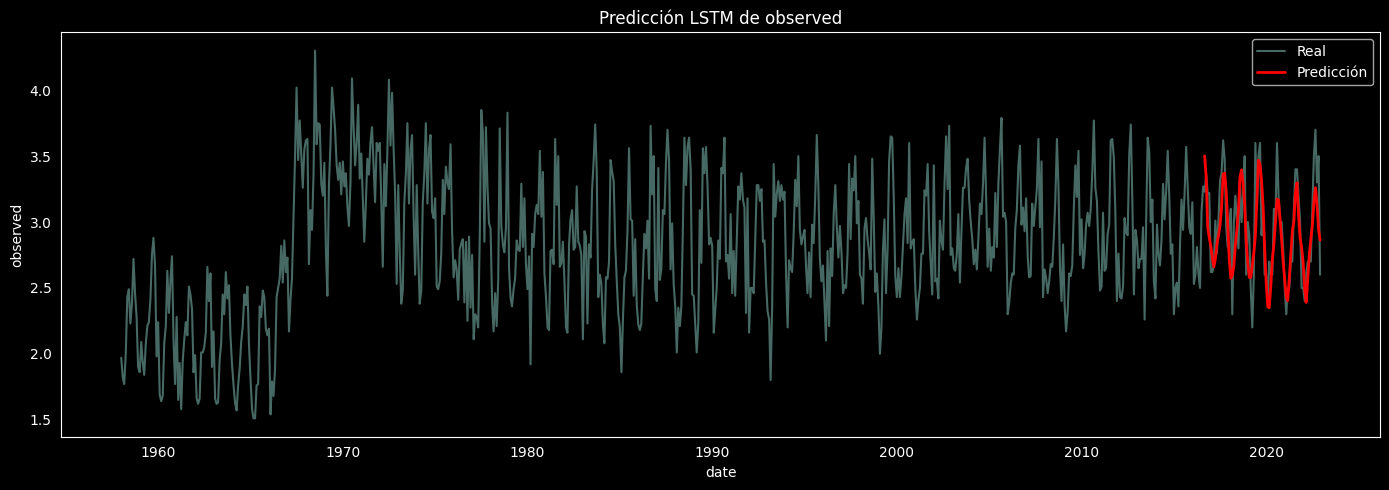

In [8]:
n_steps_o = 24

model_args_o = [
    {'layer': 'Input', 'units': (n_steps_o, 3), 'args': {}},
    {'layer': 'LSTM', 'units':32, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_o = {
    'optimizer': 'adam',
    'loss': 'mse',
    'metrics': ['mse'],
}

training_args_o = {
    'epochs': 150,
    'batch_size': 24,
    'validation_split': 0.1,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 0
}

ad_o = train_model(
    target_column=target,
    date_col='date',
    train_column='observed',
    n_steps=n_steps_o,
    training_args=training_args_o,
    model_args=model_args_o,
    compile_args=compile_args_o
)

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92804D-01    |proj g|=  9.65096D-01

At iterate    5    f=  2.37248D-01    |proj g|=  1.54550D-01

At iterate   10    f=  1.78624D-01    |proj g|=  2.68774D-02

At iterate   15    f=  1.77107D-01    |proj g|=  1.96903D-03

At iterate   20    f=  1.77080D-01    |proj g|=  4.27102D-03

At iterate   25    f=  1.77072D-01    |proj g|=  1.64153D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   

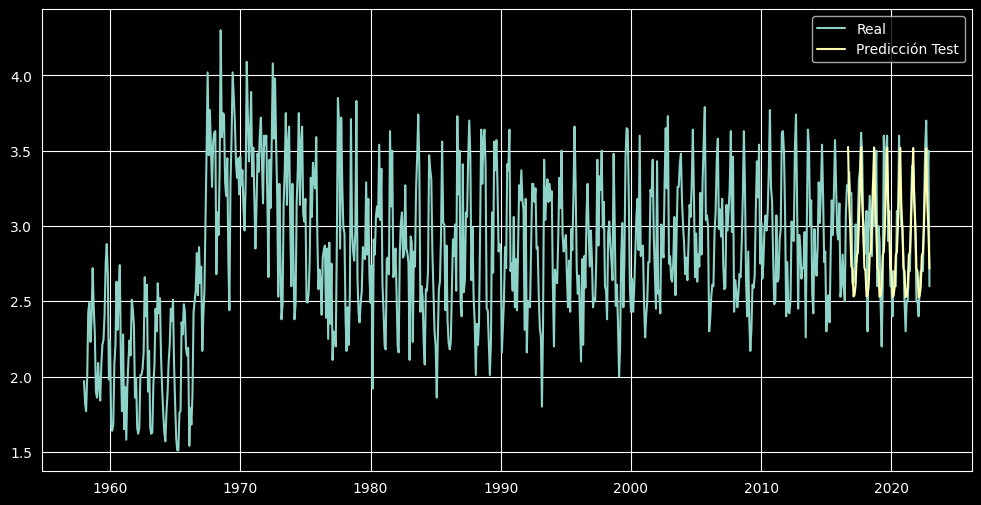

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

series = ad_o.df.set_index('date')['observed']

# División manual
train = series[:'2016-08']  # hasta diciembre 2020
test = series['2016-09':]   # desde enero 2021

# Ajustar solo con train
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
result = model.fit()

# Predecir en conjunto de prueba (in-sample)
start = test.index[0]
end = test.index[-1]
pred_test = result.predict(start=start, end=end)

# Calcular métricas
rmse = np.sqrt(mean_squared_error(test, pred_test))
mae = mean_absolute_error(test, pred_test)
print("%RMSE:", rmse * 100)
print("%MAE:", mae * 100)

# (Opcional) Predecir pasos futuros después de test
# forecast = result.get_forecast(steps=24)
# pred_future = forecast.predicted_mean
# pred_ci = forecast.conf_int()

# Graficar
plt.figure(figsize=(12,6))
plt.plot(series.index, series, label='Real')
plt.plot(pred_test.index, pred_test, label='Predicción Test')
plt.legend()
plt.show()

%RMSE: 22.904559818236365
%MAE: 18.492449642491696


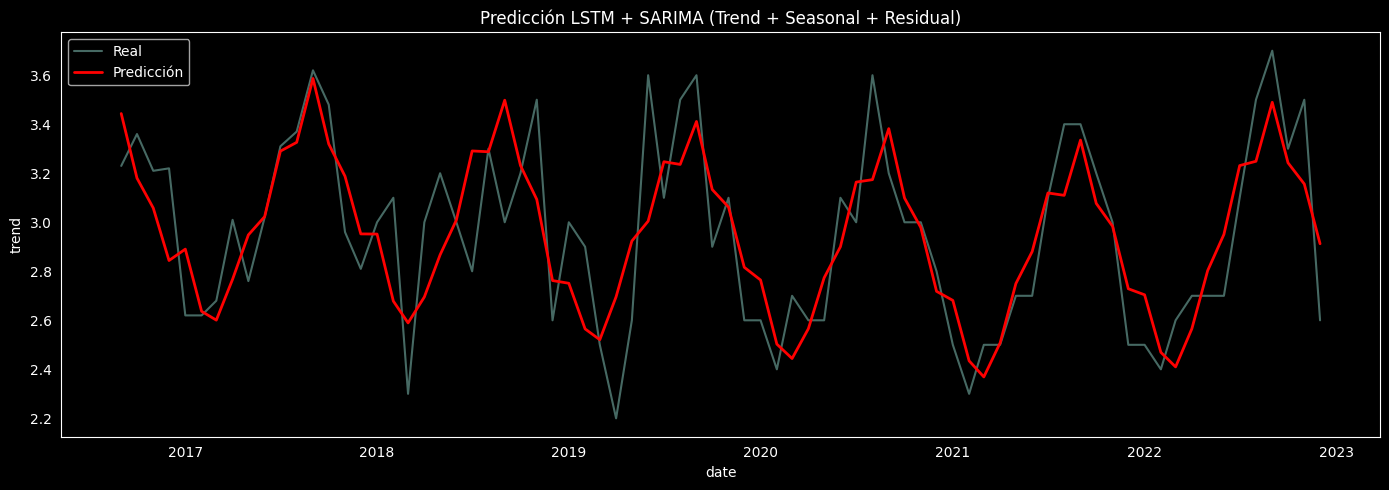

In [24]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Tomar la longitud mínima entre los arrays para que coincidan
min_len = min(
    len(ad_r._true_rescaled),
    len(ad_t._true_rescaled),
    len(ad_s._true_rescaled),
    len(pred_test.values)
)

# Convertir todo a 1D
r_true = ad_r._true_rescaled[-min_len:].flatten()
t_true = ad_t._true_rescaled[-min_len:].flatten()
s_true = ad_s._true_rescaled[-min_len:].flatten()

s_pred = ad_s._pred_rescaled[-min_len:].flatten()
t_pred = ad_t._pred_rescaled[-min_len:].flatten()
r_pred = pred_test.values[-min_len:].flatten()  # SARIMA trend o residual según tu modelo

# Sumar elemento a elemento
true_rescaled = r_true + t_true + s_true
pred_rescaled = r_pred + t_pred + s_pred

# Calcular métricas
rmse = np.sqrt(mean_squared_error(true_rescaled, pred_rescaled))
mae = mean_absolute_error(true_rescaled, pred_rescaled)
print("%RMSE:", rmse * 100)
print("%MAE:", mae * 100)

# Fechas
dates = ad_t._test_dates[-min_len:]

# Graficar
plt.figure(figsize=(14,5))
plt.plot(dates, true_rescaled, label="Real", alpha=0.5)
plt.plot(dates, pred_rescaled, label="Predicción", color="red", linewidth=2)
plt.title("Predicción LSTM + SARIMA (Trend + Seasonal + Residual)")
plt.xlabel(ad_t._date_col)
plt.ylabel(ad_t._target_col)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

%RMSE: 24.414638004883923
%MAE: 18.875685767123574


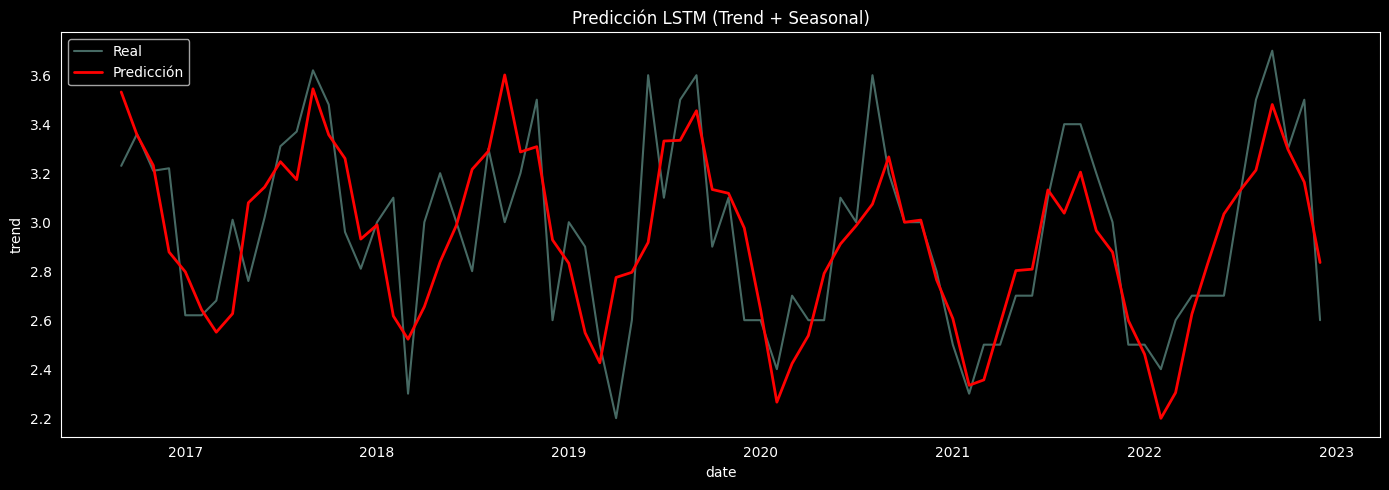

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Encontrar la longitud mínima entre las predicciones verdaderas de los modelos
min_len = min(
    len(ad_r._true_rescaled),
    len(ad_t._true_rescaled),
    len(ad_s._true_rescaled)
)

# Recortar las verdaderas y predichas para que tengan la misma longitud (solo trend + seasonal)
true_rescaled = (
    ad_t._true_rescaled[-min_len:]
    + ad_s._true_rescaled[-min_len:]
    + ad_r._true_rescaled[-min_len:]
)

pred_rescaled = (
    ad_t._pred_rescaled[-min_len:]
    + ad_s._pred_rescaled[-min_len:]
    + ad_r._pred_rescaled[-min_len:]
)

# Aplanar los arrays para matplotlib
true_rescaled = true_rescaled.flatten()
pred_rescaled = pred_rescaled.flatten()

# Calcular métricas
rmse = np.sqrt(mean_squared_error(true_rescaled, pred_rescaled))
mae = mean_absolute_error(true_rescaled, pred_rescaled)
print("%RMSE:", rmse * 100)
print("%MAE:", mae * 100)

# Usar las fechas del modelo trend para el eje x, recortadas al mismo rango
dates = ad_t._test_dates[-min_len:]

# Graficar
plt.figure(figsize=(14,5))
plt.plot(dates, true_rescaled, label="Real", alpha=0.5)
plt.plot(dates, pred_rescaled, label="Predicción", color="red", linewidth=2)
plt.title("Predicción LSTM (Trend + Seasonal)")
plt.xlabel(ad_t._date_col)
plt.ylabel(ad_t._target_col)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


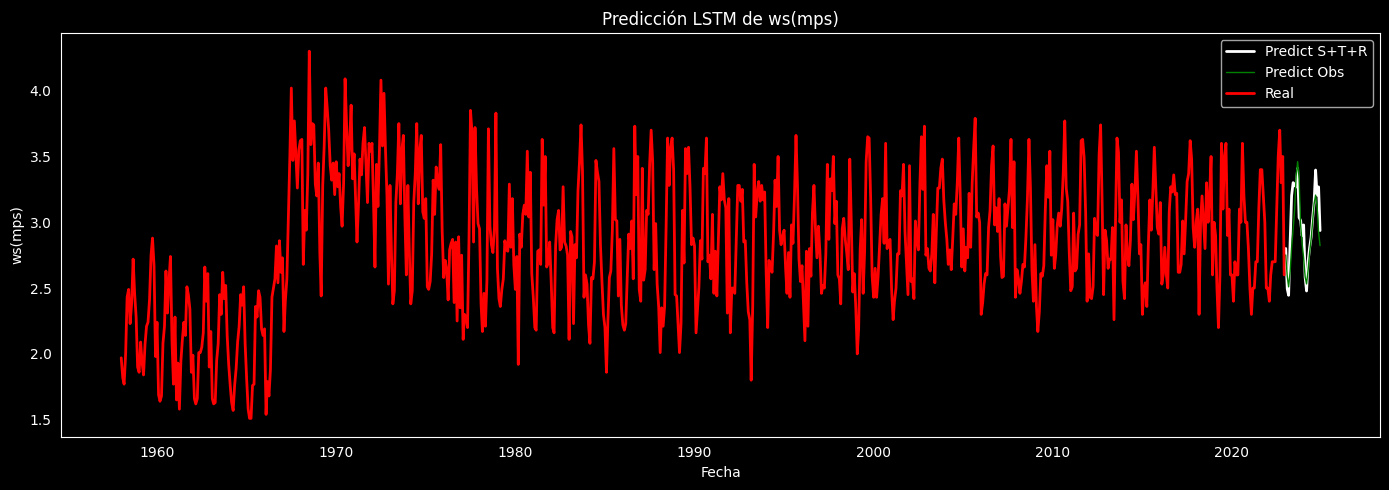

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
def build_dates(year):
    return [f'{year}{month}01' if month >= 10 else f'{year}0{month}01' for month in range(1, 13)]
dates_input = build_dates(2023)
dates_input = dates_input + build_dates(2024)
predicts = []
predicts1 = []
for date in dates_input:
    _predict = ad_r.predict_for_date(date)
    _predict += ad_t.predict_for_date(date)
    _predict += ad_s.predict_for_date(date)
    predicts.append(_predict)

    _predict = ad_o.predict_for_date(date)
    predicts1.append(_predict)


plt.figure(figsize=(14,5))
plt.plot(pd.to_datetime(dates_input, format='%Y%m%d'), predicts, label="Predict S+T+R", color='white', linewidth=2)
plt.plot(pd.to_datetime(dates_input, format='%Y%m%d'), predicts1, label="Predict Obs", color='green', linewidth=1)
plt.plot(ad_r.df['date'], ad_r.df['observed'], label="Real", color="red", linewidth=2)
plt.title("Predicción LSTM de " + target)
plt.xlabel("Fecha")
plt.ylabel(target)
plt.legend()
plt.grid()
plt.tight_layout()